# Financial Inclusion in Africa Starter Notebook


This is a simple starter notebook to get started with the Financial Inclusion Competition on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### Read files

In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDefinitions.csv')

### Some basic EDA

In [3]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [4]:
# Preview the first five rows of the train set
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Preview the first five rows of the test set
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [6]:
# Preview the first five rows of the sample submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [7]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (23524, 13)
The shape of the test set is: (10086, 12)


## Combine train and test set for easy preprocessing 

In [8]:
# mapping the bank account with 0 to NO and 1 to YES
train['bank_account'] = train['bank_account'].map({'No':0, 'Yes':1})

In [9]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (33610, 13)


In [10]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
33605,Uganda,2018,uniqueid_2998,NaN,Rural,No,2,62,Female,Spouse,Married/Living together,Primary education,Self employed
33606,Uganda,2018,uniqueid_2999,NaN,Urban,Yes,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed
33607,Uganda,2018,uniqueid_3000,NaN,Urban,Yes,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income
33608,Uganda,2018,uniqueid_3001,NaN,Rural,Yes,6,28,Female,Spouse,Married/Living together,Primary education,Self employed
33609,Uganda,2018,uniqueid_3002,NaN,Urban,Yes,7,16,Male,Other relative,Single/Never Married,Secondary education,Other Income


In [11]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33610 entries, 0 to 33609
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 33610 non-null  object 
 1   year                    33610 non-null  int64  
 2   uniqueid                33610 non-null  object 
 3   bank_account            23524 non-null  float64
 4   location_type           33610 non-null  object 
 5   cellphone_access        33610 non-null  object 
 6   household_size          33610 non-null  int64  
 7   age_of_respondent       33610 non-null  int64  
 8   gender_of_respondent    33610 non-null  object 
 9   relationship_with_head  33610 non-null  object 
 10  marital_status          33610 non-null  object 
 11  education_level         33610 non-null  object 
 12  job_type                33610 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 3.3+ MB


### Distribution of the target variable

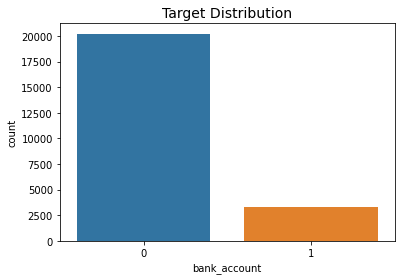

In [12]:
sns.countplot(train.bank_account)
plt.title('Target Distribution', fontdict={'size':14});

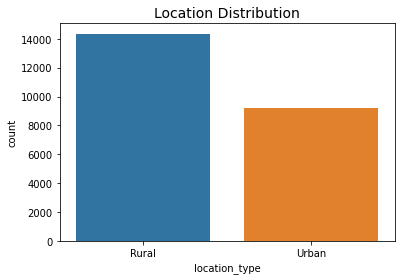

In [13]:
sns.countplot(train.location_type)
plt.title('Location Distribution', fontdict={'size':14});

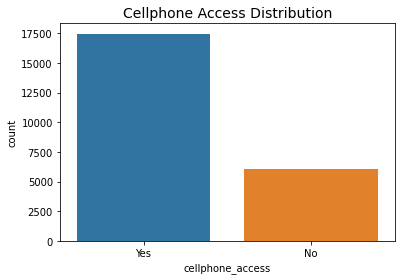

In [14]:
sns.countplot(train.cellphone_access)
plt.title('Cellphone Access Distribution', fontdict={'size':14});

Here we see the overall distribution for the whole train set. Can you see if there are any differences due to country?

### Number of unique values per categorical column

In [15]:
# Check unique values for each categorical column
cat_cols = ['country',	'location_type',	'cellphone_access',	'gender_of_respondent',	'relationship_with_head', 'marital_status', 'education_level',	'job_type']
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

country
['Kenya' 'Rwanda' 'Tanzania' 'Uganda'] 

location_type
['Rural' 'Urban'] 

cellphone_access
['Yes' 'No'] 

gender_of_respondent
['Female' 'Male'] 

relationship_with_head
['Spouse' 'Head of Household' 'Other relative' 'Child' 'Parent'
 'Other non-relatives'] 

marital_status
['Married/Living together' 'Widowed' 'Single/Never Married'
 'Divorced/Seperated' 'Dont know'] 

education_level
['Secondary education' 'No formal education'
 'Vocational/Specialised training' 'Primary education'
 'Tertiary education' 'Other/Dont know/RTA'] 

job_type
['Self employed' 'Government Dependent' 'Formally employed Private'
 'Informally employed' 'Formally employed Government'
 'Farming and Fishing' 'Remittance Dependent' 'Other Income'
 'Dont Know/Refuse to answer' 'No Income'] 



### Feature Engineering


#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [16]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,year,uniqueid,bank_account,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_No formal education,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,uniqueid_1,1.0,3,24,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,2018,uniqueid_2,0.0,5,70,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2018,uniqueid_3,1.0,5,26,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,2018,uniqueid_4,0.0,5,34,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2018,uniqueid_5,0.0,8,26,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((23524, 42), (10086, 42))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [18]:
# Select main columns to be used in training
#main_cols = all_data.columns.difference(date_cols+['ID', 'bank_account'])
main_cols = all_data.columns.difference(['uniqueid', 'bank_account'])
X = train_df[main_cols]
y = train_df['bank_account']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the accuracy score of the model
accuracy_score(y_pred,y_test)

0.889628790025503

### Making predictions of the test set and creating a submission file

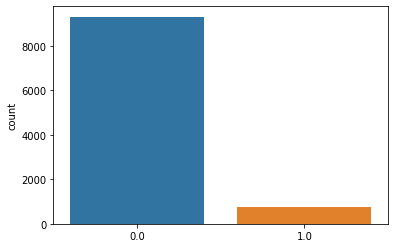

In [19]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [20]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

In [21]:
files.download('Baseline.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************